In [16]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt

In [17]:
def _clean(x, default='float'):   
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in tqdm.tqdm(x.columns):
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

from sklearn.ensemble import IsolationForest
def _remove_outliers(x, method='isoforest'):
    '''
    x: pandas data frame or numpy array
    method: isoforest 
    '''
    if method=='isoforest': 
        # isolation forest       
        model = IsolationForest(n_estimators=100,)
    
    # consider Angle Based Outlier Detection
    # consider using sample aggregate of z-scores
    return x
    
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence
    
    return True

def _dimension_reduction(x, method='PCA', dimension=3):
    # method: PCA, SAE, UMAP

    return True   
    
                     
def _outliers_modified_z_score(ys, threshold = 3.5):
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return modified_z_scores, np.where(np.abs(modified_z_scores) > threshold)
    

In [18]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)

In [19]:
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/" # "/media/bramvanes/Extra/DATA/RexR/2018" #  #"/media/bramvanes/Extra/DATA/RexR/2018" #
gene_expression = pd.read_table(sourceDir+"/Lung/Lung_GeneExpression.txt", sep="\t")

affx_labels = list(gene_expression.set_index('Gene').filter(axis=0, regex=r"^(AFFX.*)").index) # AFFX 
gene_expression = gene_expression.drop(affx_labels, axis=0)

gene_expression = gene_expression[np.isfinite(gene_expression.Start)]
gene_expression = gene_expression[np.isfinite(gene_expression.Stop)]

gene_expression.Start = gene_expression.Start.astype(int).astype(str)
gene_expression.Stop = gene_expression.Stop.astype(int).astype(str)
gene_expression.Chr = gene_expression.Chr.astype(str)
gene_expression.Gene = gene_expression.Gene.astype(str)

gene_expression['GenX'] = gene_expression[['Gene', 'Chr', 'Start', 'Stop']].apply(lambda x: '.'.join(x), axis=1)
_map_RNA = gene_expression[['Gene', 'GenX']]
gene_expression = gene_expression.drop(['Gene', 'Chr', 'Start', 'Stop'], axis=1)

# remove duplicate GenX values
gene_expression = gene_expression.copy().loc[~gene_expression.GenX.duplicated(keep='first')]

dict_RNA={'RNA_StrandPlus': _clean(get_transposed(gene_expression\
                                                  .loc[gene_expression.Strand=='+'].drop(['Strand'], axis=1))),
          'RNA_StrandMin':  _clean(get_transposed(gene_expression\
                                                  .loc[gene_expression.Strand=='-'].drop(['Strand'], axis=1)))                                
          }


In [20]:
# CLEAN MEMORY
del gene_expression
gc.collect()

35

In [21]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

In [22]:
merged_RNA_min = dict_RNA['RNA_StrandMin'].merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)
merged_RNA_plus = dict_RNA['RNA_StrandPlus'].merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)

In [23]:
# There are patients with multiple measurements, we simply take the mean 
gene_columns = [_col for _col in merged_RNA_min.columns if 'GenX' in _col]
other_columns = [_col for _col in merged_RNA_min.columns if 'GenX' not in _col]

merged_RNA_min['patient_nr'] = merged_RNA_min.index
tmp_min = merged_RNA_min[['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
merged_RNA_min = merged_RNA_min.copy()[other_columns].merge(tmp_min, how='right', left_index=True, right_on='patient_nr')
merged_RNA_min = merged_RNA_min.loc[~merged_RNA_min.index.duplicated(keep='first')]

gene_columns = [_col for _col in merged_RNA_plus.columns if 'GenX' in _col]
other_columns = [_col for _col in merged_RNA_plus.columns if 'GenX' not in _col]

merged_RNA_plus['patient_nr'] = merged_RNA_plus.index
tmp_plus = merged_RNA_plus[['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
merged_RNA_plus = merged_RNA_plus.copy()[other_columns].merge(tmp_plus, how='right', left_index=True, right_on='patient_nr')
merged_RNA_plus = merged_RNA_plus.loc[~merged_RNA_plus.index.duplicated(keep='first')]

# Bias correction functions
## L/S, cohort-based normalisation

Mean-based $$\mathbf{x}^*=\frac{\mathbf{x}-\overline{\mathbf{x}}}{\sigma}$$


Median-based $$\mathbf{x}^*=\frac{\mathbf{x}-median(\mathbf{x})}{IQR}$$






In [24]:
# L/S
def _preprocess(df, cohorts = [], scaler = "standard", bias_removal = False, col_range = None, min_cohort_size=10, debug=False):
        if col_range is None:
            gene_columns = [_col for _col in df.columns if 'GenX' in _col]  
        else:                      
            cr = range(col_range[0], col_range[1])
            gene_columns = df.columns[cr]
        
        if len(cohorts)==0:
            cohorts = df.batch_number.unique().tolist()
        
        # MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), Normalizer()
        if scaler == "standard":
            scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        elif scaler == "minmax":
            scaler = preprocessing.MinMaxScaler()
        elif scaler == "maxabs":
            scaler = preprocessing.MaxAbsScaler()
        elif scaler == "robust":
            scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0), 
                                                    with_scaling=True, with_centering=True)
        elif scaler in ["normalizer", "normaliser"]:
            scaler = preprocessing.Normalizer()

        if bias_removal == True:
            print("- "*30, 'Removing cohort biases')
            i=0; itot=len(cohorts)
            
            for cohort in cohorts: # easy to parallelise...use numpy and pooling...
                i+=1
                ch = df['batch_number']==cohort
                if sum(ch)<min_cohort_size:
                    print("Skipping cohort {}, because of low sample count: {}".format(cohort, sum(ch)))
                else:
                    if debug==False:
                        try:
                            res = scaler.fit_transform(df.loc[ch,gene_columns].values)
                            df.loc[ch,gene_columns] = pd.DataFrame(data=res, index=ch[ch].index, columns=gene_columns)
                            print("{}/{}, Corrected cohort {}, with {} samples".format(i, itot, cohort, sum(ch))) 
                        except Exception as e:
                            print("ERROR", e, "cohort:"+cohort)
                            print("index:",ch)
                            print("target:", df.loc[ch,gene_columns].shape) 
                            print("replacement:", res.shape)
                    else:
                        for _col in gene_columns: # for debugging
                            df_temp = df.loc[ch, _col].copy() 
                            try:
                                df.loc[ch, _col] = (df_temp-df_temp.mean())/df_temp.std()
                            except Exception as e:
                                print("ERROR", e, "gene:"+_col, "cohort:"+cohort)
        else:
            ch = df["array-batch"].isin(cohorts)
            df.loc[ch,gene_columns] = scaler.fit_transform(df.loc[ch,gene_columns])
            

        df = df[df["batch_number"].isin(cohorts)]
        return df  
    
def _quantile_normalisation():
    return True

In [34]:
# L/S correction
merged_RNA_plus_CBC_LS = _preprocess(merged_RNA_plus.copy(), 
                                     col_range=None, 
                                     bias_removal=True, 
                                     debug=False, 
                                     scaler='robust') # 29905
# mean shift 
gene_columns = [_col for _col in merged_RNA_plus_CBC_LS.columns if 'GenX' in _col]
merged_RNA_plus_CBC_LS.loc[:, gene_columns] += merged_RNA_plus.loc[:, gene_columns].mean(axis=0)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/43, Corrected cohort 52.73.0, with 15 samples
2/43, Corrected cohort 58.76.0, with 39 samples
3/43, Corrected cohort 119.75.0, with 54 samples
4/43, Corrected cohort 144.69.0, with 52 samples
5/43, Corrected cohort 84.72.0, with 31 samples
6/43, Corrected cohort 39.67.0, with 36 samples
7/43, Corrected cohort 77.67.0, with 26 samples
8/43, Corrected cohort 53.65.0, with 13 samples
9/43, Corrected cohort 101.61.0, with 29 samples
10/43, Corrected cohort 23.74.0, with 22 samples
Skipping cohort 208.52.0, because of low sample count: 9
12/43, Corrected cohort 283.49.0, with 48 samples
13/43, Corrected cohort 60.69.0, with 18 samples
14/43, Corrected cohort 140.61.0, with 36 samples
15/43, Corrected cohort 193.55.0, with 40 samples
16/43, Corrected cohort 159.57.0, with 21 samples
17/43, Corrected cohort 293.49.0, with 25 samples
18/43, Corrected cohort 276.50.0, with 21 samples
19/43, Corrected cohort 41

In [35]:
merged_RNA_min_CBC_LS = _preprocess(merged_RNA_min.copy(), 
                                    col_range=None,
                                    bias_removal=True, 
                                    debug=False,
                                    scaler='robust') # 29905
# mean shift 
gene_columns = [_col for _col in merged_RNA_min_CBC_LS.columns if 'GenX' in _col]
merged_RNA_min_CBC_LS.loc[:, gene_columns] += merged_RNA_min.loc[:, gene_columns].mean(axis=0)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/43, Corrected cohort 52.73.0, with 15 samples
2/43, Corrected cohort 58.76.0, with 39 samples
3/43, Corrected cohort 119.75.0, with 54 samples
4/43, Corrected cohort 144.69.0, with 52 samples
5/43, Corrected cohort 84.72.0, with 31 samples
6/43, Corrected cohort 39.67.0, with 36 samples
7/43, Corrected cohort 77.67.0, with 26 samples
8/43, Corrected cohort 53.65.0, with 13 samples
9/43, Corrected cohort 101.61.0, with 29 samples
10/43, Corrected cohort 23.74.0, with 22 samples
Skipping cohort 208.52.0, because of low sample count: 9
12/43, Corrected cohort 283.49.0, with 48 samples
13/43, Corrected cohort 60.69.0, with 18 samples
14/43, Corrected cohort 140.61.0, with 36 samples
15/43, Corrected cohort 193.55.0, with 40 samples
16/43, Corrected cohort 159.57.0, with 21 samples
17/43, Corrected cohort 293.49.0, with 25 samples
18/43, Corrected cohort 276.50.0, with 21 samples
19/43, Corrected cohort 41

Text(0.5,1,'Cohort comparison for GenX_CD99.chrX.2691179.2741309 (+ strand) without scaling')

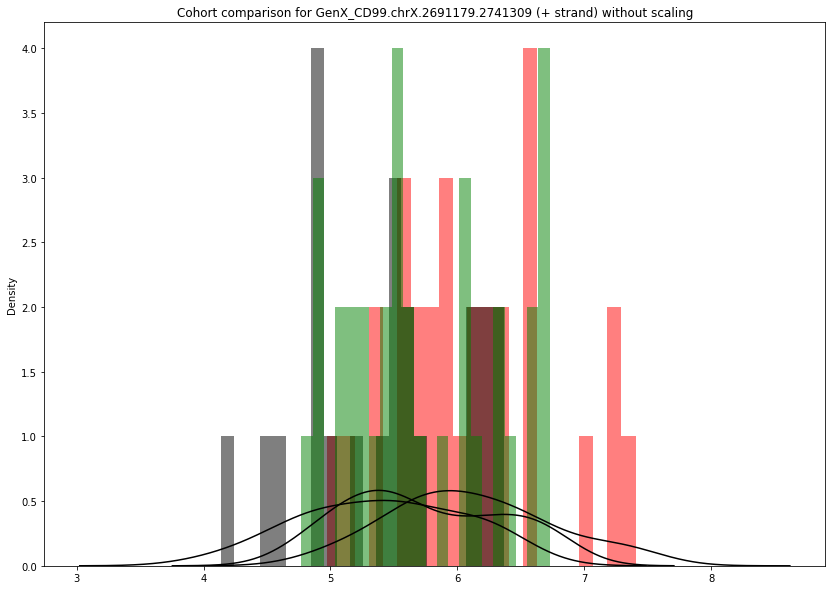

In [36]:
test_gene = 'GenX_CD99.chrX.2691179.2741309'
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')
plt.title('Cohort comparison for {} (+ strand) without scaling'.format(test_gene))

Text(0.5,1,'Cohort comparison for GenX_CD99.chrX.2691179.2741309 (+ strand) using standard scaling')

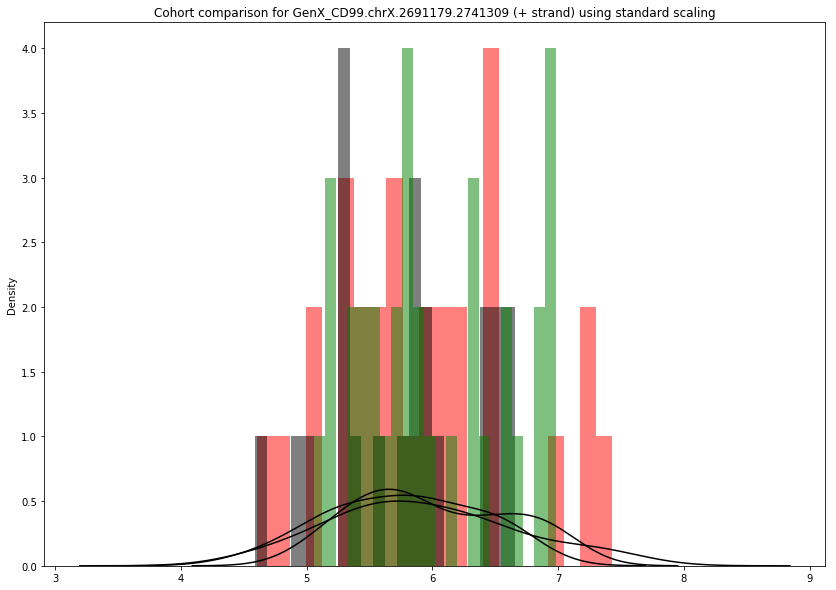

In [37]:
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')
plt.title('Cohort comparison for {} (+ strand) using standard scaling'.format(test_gene))

In [38]:
merged_RNA_min_CBC_LS.to_csv(sourceDir+"/Lung/_prepped/RNAexpression_minStrand_LSquant.csv.gzip",
                compression="gzip")

merged_RNA_plus_CBC_LS.to_csv(sourceDir+"/Lung/_prepped/RNAexpression_plusStrand_LSquant.csv.gzip",
                compression="gzip")

# Cohort bias detection

a-priori and a-posteriori


In [39]:
import rpy2.robjects as robjects
import numpy as np
from rpy2.robjects.packages import importr
preprocessCore = importr('preprocessCore')


In [110]:
def _cohort_bias_detection(df, min_samples=10, n_comp=3):
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    cohorts = df.batch_number.unique().tolist()
    red_data_dict = {}
    for _cohort in tqdm(cohorts):
        ch = df['batch_number']==_cohort
        X = df.loc[ch, gene_columns]
        if X.shape[0]>min_samples:
            # PCA 3
            reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
            # put components in a dictionary with cohort as key
            X_red = reducer.fit_transform(X)
            #
            red_data_dict[_cohort] = {}
            red_data_dict[_cohort]['data'] = X_red
            red_data_dict[_cohort]['reducer'] = reducer
    
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    red_data_dict['ALL'] = 
    
    return red_data_dict

In [97]:
merged_RNA_min_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_plus_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_min_LS_median_PCA = _cohort_bias_detection(merged_RNA_min_CBC_LS)
merged_RNA_plus_LS_median_PCA = _cohort_bias_detection(merged_RNA_plus_CBC_LS)

100%|██████████| 43/43 [00:03<00:00, 13.00it/s]


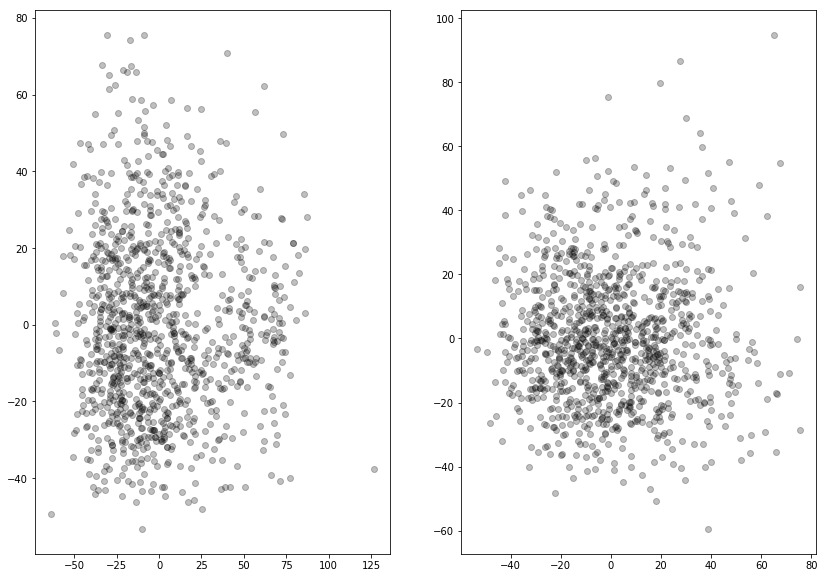

In [109]:
res_dict = merged_RNA_min_PCA

cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for _cohort in cohorts:
    ax[0].plot(res_dict[_cohort]['data'][:,0], 
             res_dict[_cohort]['data'][:,1], 'o', color='black', alpha=0.25)
    ax[1].plot(res_dict[_cohort]['data'][:,1], 
             res_dict[_cohort]['data'][:,2], 'o', color='black', alpha=0.25)    

    